In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import timm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from PIL import Image
from torch import nn

from src import attacks
from src.imagenet_labels import IMAGENET_LABELS
from src.utils import normalize_model
from src import models  # Necessary to register custom models to timm

In [4]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False

In [5]:
plt.rcParams["savefig.bbox"] = 'tight'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
output_dir = Path("outputs") / "advex_example"

In [6]:
# Set up non-robust model
model = timm.create_model("resnet50", pretrained=True)
model = normalize_model(model, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
model = model.to(device)
model.eval()

# Set up robust model
robust_model = timm.create_model("resnet50_gelu_adv", checkpoint_path="../checkpoints/advres50_gelu.pth")
robust_model = normalize_model(robust_model, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
robust_model = robust_model.to(device)
robust_model.eval();

In [7]:
# Set-up input image
x_pil = Image.open("castle.jpg")
x = F.pil_to_tensor(x_pil)
x = F.resize(x, (224, 224), interpolation=F.InterpolationMode('bicubic'))
x = F.center_crop(x, (224, 224))
x = x.to(torch.float) / 255
x = x.unsqueeze(0)
x = x.to(device)
x.size()

torch.Size([1, 3, 224, 224])

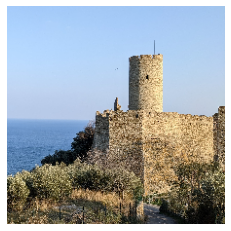

In [8]:
plt.imshow(F.to_pil_image(x[0].cpu()))
plt.axis('off');
plt.savefig(output_dir / "x.jpg")

In [9]:
# Set-up attack
attack_criterion = nn.NLLLoss(reduction="sum")
eps = 4 / 255
pgd_steps = 10
attack = attacks.make_attack("pgd", eps, 1.5 * eps / pgd_steps, pgd_steps, "linf", (0, 1),
                             attack_criterion)

## Non-robust model

In [10]:
y = model(x).argmax()
print(IMAGENET_LABELS[y])

castle


In [11]:
x_adv = attack(model, x, y.unsqueeze(0))
y_adv = model(x_adv).argmax()
print(IMAGENET_LABELS[y_adv])

monastery


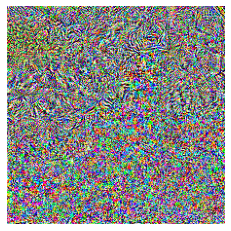

In [12]:
pert = ((x_adv - x) + eps) / (2 * eps)
plt.imshow(F.to_pil_image(pert[0].cpu()))
plt.axis('off');
plt.savefig(output_dir / "pert.jpg")

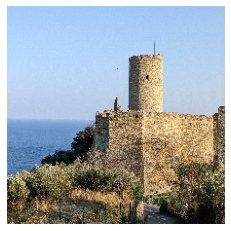

In [13]:
plt.imshow(F.to_pil_image(x_adv[0].cpu()))
plt.axis('off');
plt.savefig(output_dir / "x_adv.jpg")

## Robust model

In [14]:
robust_y = robust_model(x).argmax()
print(IMAGENET_LABELS[robust_y])

castle


In [15]:
robust_x_adv = attack(robust_model, x, y.unsqueeze(0))
robust_y_adv = model(robust_x_adv).argmax()
print(IMAGENET_LABELS[robust_y_adv])

castle


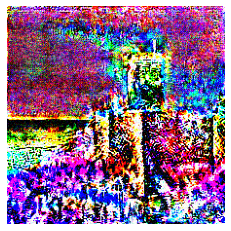

In [16]:
robust_pert = ((robust_x_adv - x) + eps) / (2 * eps)
plt.imshow(F.to_pil_image(robust_pert[0].cpu()))
plt.axis('off');
plt.savefig(output_dir / "robust_pert.jpg")

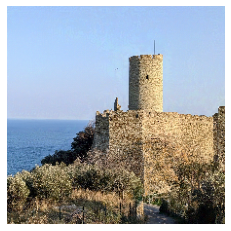

In [17]:
plt.imshow(F.to_pil_image(robust_x_adv[0].cpu()))
plt.axis('off');
plt.savefig(output_dir / "robust_x_adv.jpg")